In [ ]:
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from spp.convex_sets import Singleton, Polyhedron, Ellipsoid
from spp.convex_functions import TwoNorm, SquaredTwoNorm
from spp.graph import GraphOfConvexSets
from spp.shortest_path import ShortestPathProblem

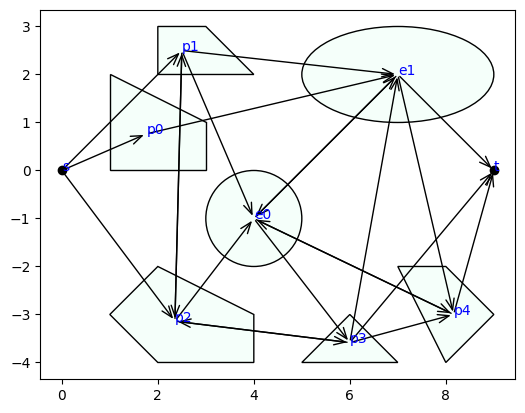

In [2]:
# convex sets
singletons = (
    Singleton((0, 0)),
    Singleton((9, 0)),
)
polyhedra = (
    Polyhedron.from_vertices(([1, 0], [1, 2], [3, 1], [3, 0])),
    Polyhedron.from_vertices(([4, 2], [3, 3], [2, 2], [2, 3])),
    Polyhedron.from_vertices(([2, -2], [1, -3], [2, -4], [4, -4], [4, -3])),
    Polyhedron.from_vertices(([5, -4], [7, -4], [6, -3])),
    Polyhedron.from_vertices(([7, -2], [8, -2], [9, -3], [8, -4])),
)
ellipsoids = (
    Ellipsoid((4, -1), ([1, 0], [0, 1])),
    Ellipsoid((7, 2), ([.25, 0], [0, 1])),
)
sets = singletons + polyhedra + ellipsoids

# label for the vertices
vertices = ['s', 't']
vertices += [f'p{i}' for i in range(len(polyhedra))]
vertices += [f'e{i}' for i in range(len(ellipsoids))]

# add convex sets to the graph
G = GraphOfConvexSets()
G.add_sets(sets, vertices)
G.set_source('s')
G.set_target('t')

# edges
H = np.hstack((np.eye(2), -np.eye(2)))
l = TwoNorm(H)
edges = {
    's': ('p0', 'p1', 'p2'),
    'p0': ('e1',),
    'p1': ('p2', 'e0', 'e1'),
    'p2': ('p1', 'p3', 'e0'),
    'p3': ('t', 'p2', 'p4', 'e1'),
    'p4': ('t', 'e0'),
    'e0': ('p3', 'p4', 'e1'),
    'e1': ('t', 'p4', 'e0')
}
for u, vs in edges.items():
    for v in vs:
        G.add_edge(u, v, l)
        
# draw convex sets and edges
plt.figure()
G.draw_sets()
G.draw_edges()
G.label_sets()
plt.show()

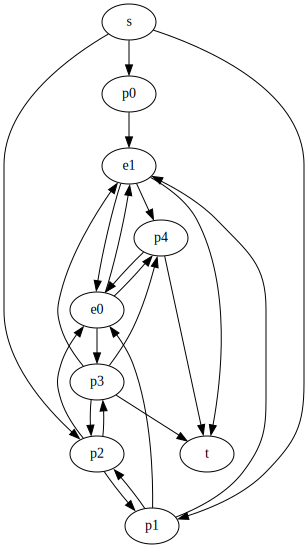

In [3]:
G.graphviz()

In [4]:
spp = ShortestPathProblem(G, relaxation=0)
sol = spp.solve()

print('Cost:', sol.cost)
print('\nFlows:')
for k, edge in enumerate(G.edges):
    flow = round(abs(sol.primal.phi[k]), 4)
    print(edge, flow)

Cost: 9.28580885075831

Flows:
('s', 'p0') 1.0
('s', 'p1') 0.0
('s', 'p2') 0.0
('p0', 'e1') 1.0
('p1', 'p2') 0.0
('p1', 'e0') 0.0
('p1', 'e1') 0.0
('p2', 'p1') 0.0
('p2', 'p3') 0.0
('p2', 'e0') 0.0
('p3', 't') 0.0
('p3', 'p2') 0.0
('p3', 'p4') 0.0
('p3', 'e1') 0.0
('p4', 't') 0.0
('p4', 'e0') 0.0
('e0', 'p3') 0.0
('e0', 'p4') 0.0
('e0', 'e1') 0.0
('e1', 't') 1.0
('e1', 'p4') 0.0
('e1', 'e0') 0.0


In [5]:
# edge lenghts
l2 = SquaredTwoNorm(H)
G2 = deepcopy(G)
for e in G2.edges:
    G2.set_edge_length(e, l2)

spp2 = ShortestPathProblem(G2, relaxation=0)
sol2 = spp2.solve()

print('Cost:', sol2.cost)
print('\nFlows:')
for k, edge in enumerate(G2.edges):
    flow = round(abs(sol2.primal.phi[k]), 4)
    print(edge, flow)

Cost: 26.49999998032824

Flows:
('s', 'p0') 0.0
('s', 'p1') 0.0
('s', 'p2') 1.0
('p0', 'e1') 0.0
('p1', 'p2') 0.0
('p1', 'e0') 0.0
('p1', 'e1') 0.0
('p2', 'p1') 0.0
('p2', 'p3') 0.0
('p2', 'e0') 1.0
('p3', 't') 0.0
('p3', 'p2') 0.0
('p3', 'p4') 1.0
('p3', 'e1') 0.0
('p4', 't') 1.0
('p4', 'e0') 0.0
('e0', 'p3') 1.0
('e0', 'p4') 0.0
('e0', 'e1') 0.0
('e1', 't') 0.0
('e1', 'p4') 0.0
('e1', 'e0') 0.0


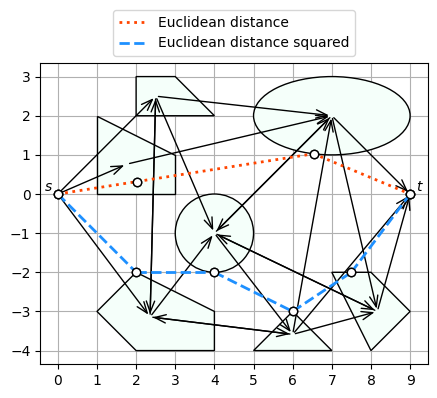

In [6]:
plt.figure(figsize=(5,5))
G.draw_sets()
G.draw_edges()

offset = np.array([.25, 0])
plt.text(*(G.source_set.center - offset), r'$s$', ha='center', va='bottom')
plt.text(*(G.target_set.center + offset), r'$t$', ha='center', va='bottom')

plt.plot([np.nan] * 2, c='orangered', linestyle=':', label='Euclidean distance', linewidth=2)
plt.plot([np.nan] * 2, c='dodgerblue', linestyle='--', label='Euclidean distance squared', linewidth=2)
G.draw_path(sol.primal.phi, sol.primal.x, color='orangered', linestyle=':', linewidth=2)
G.draw_path(sol2.primal.phi, sol2.primal.x, color='dodgerblue', linestyle='--', linewidth=2)

plt.xticks(range(10))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
plt.grid()
# plt.savefig('2d_setup.pdf', bbox_inches='tight')

In [ ]:
scales = np.logspace(-2, 2, 200)
c_micp = []
c_relaxation = []
c_micp2 = []
c_relaxation2 = []
for s in scales:
    
    G_scaled = deepcopy(G)
    G_scaled.scale(s)
    spp = ShortestPathProblem(G_scaled, relaxation=0)
    c_micp.append(spp.solve().cost)
    spp = ShortestPathProblem(G_scaled, relaxation=1)
    c_relaxation.append(spp.solve().cost)
    
    G2_scaled = deepcopy(G2)
    G2_scaled.scale(s)
    spp = ShortestPathProblem(G2_scaled, relaxation=0)
    c_micp2.append(spp.solve().cost)
    spp = ShortestPathProblem(G2_scaled, relaxation=1)
    c_relaxation2.append(spp.solve().cost)

In [ ]:
def micp_vs_relaxation(c_micp, c_relaxation):
    plt.plot(scales, c_micp, label='MICP', linestyle='-', linewidth=2)
    plt.plot(scales, c_relaxation, label='Convex relaxation', linestyle='--', linewidth=2)
    plt.ylabel('Cost')
    plt.xlim([scales[0], scales[-1]])
    plt.xscale('log')
    plt.grid(1)

In [ ]:
plt.figure(figsize=(3.5, 4))
plt.subplots_adjust(hspace=.25)

plt.subplot(2, 1, 1)
plt.plot(scales, c_micp, label='MICP', linestyle='-', c='orangered', linewidth=2)
plt.plot(scales, c_relaxation, label='Relaxation', linestyle='-.', c='k', linewidth=2)
plt.ylabel('Cost')
plt.xlim([scales[0], scales[-1]])
plt.xscale('log')
plt.grid(1)
plt.gca().set_xticklabels([])
# plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
plt.legend(loc=1)
plt.gca().locator_params(nbins=8, axis='y')
plt.title('Euclidean distance')

plt.subplot(2, 1, 2)
plt.plot(scales, c_micp2, label='MICP', linestyle='-', c='dodgerblue', linewidth=2)
plt.plot(scales, c_relaxation2, label='Relaxation', linestyle='-.', c='k', linewidth=2)
plt.ylabel('Cost')
plt.xlim([scales[0], scales[-1]])
plt.xscale('log')
plt.grid(1)
plt.legend(loc=1)
plt.xlabel(r'Set size $\sigma$')
plt.gca().locator_params(nbins=8, axis='y')
plt.title('Euclidean distance squared')

plt.savefig('2d_results.pdf', bbox_inches='tight')